In [104]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler


import seaborn as sns

In [103]:
#!pip install seaborn

In [2]:
data = pd.read_csv('G:\\MiSiS\\hakaton\\new\\statistics-07-20.csv', sep = ';')

In [3]:
# Чтобы увидеть все колонки
pd.set_option('display.max_columns', None)
# Отображать данные float с 1 знаком после запятой
pd.options.display.float_format ='{:,.0f}'.format


# Анализ данных

In [4]:
data.head()

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,operation_st_esr,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
0,NaN,NaN,62827035,"984,700",NaN,NaN,NaN,2,81,2020-07-16 03:40:00,"984,502","2,000,038,950",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,62827035,"862,201",20,NaN,"421,034",NaN,18,2020-07-16 14:10:00,"984,700","2,002,025,651",NaN,"93,149,858",60,NaN,"68,398,528",NaN,NaN,249,NaN
2,NaN,NaN,62827316,"863,007",NaN,NaN,NaN,2,80,2020-07-16 14:50:00,"863,007","2,001,933,494",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,62827381,"862,108",NaN,NaN,NaN,2,80,2020-07-16 14:16:00,"862,108","2,001,930,794",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,62845730,"887,904",20,NaN,"421,034",NaN,19,2020-07-16 15:15:00,"967,808","2,000,038,604",NaN,"81,195,103",60,NaN,"52,682,351",NaN,NaN,248,NaN


In [5]:
data = data[(data['operation_car'].isna() == False) & (data['operation_st_esr'].isna() == False)].copy()

In [6]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

In [7]:
def find_duplicates_by_columns(df):  # функция для поиска дубликатов по столбцам
    duplicates = []
    column = []
    for i in df.columns:
        duplicates.append(df[i].duplicated().sum())
        column.append(i)
    duplicates = pd.Series(duplicates) 
    column = pd.Series(column) 
    return pd.concat([column, duplicates], axis = 1,
                     keys = ['column', 'duplicates']).sort_values(by = 'duplicates',ascending = False).head(40)

In [8]:
missing_data(data)

,Total,Percent
danger,3536099,97
rod_train,2623213,72
weight_brutto,2622868,72
tare_weight,2543576,70
adm,2543576,70
ssp_station_id,2228617,61
operation_train,2221823,61
ssp_station_esr,2221822,61
index_train,2221822,61
gruz,1771902,49


In [9]:
find_duplicates_by_columns(data)

,column,duplicates
5,danger,3648083
7,loaded,3648081
12,operation_train,3648075
14,rodvag,3648073
4,adm,3648071
8,operation_car,3648065
15,rod_train,3648058
1,length,3648008
19,tare_weight,3647750
11,operation_st_id,3647341


In [10]:
# Проверяем где и сколько nan 
data.isna().sum()

index_train         2221822
length              1714849
car_number                0
destination_esr       58255
adm                 2543576
danger              3536099
gruz                1771902
loaded              1104509
operation_car             0
operation_date            0
operation_st_esr          0
operation_st_id           0
operation_train     2221823
receiver            1764038
rodvag              1117313
rod_train           2623213
sender              1764038
ssp_station_esr     2221822
ssp_station_id      2228617
tare_weight         2543576
weight_brutto       2622868
dtype: int64

In [11]:
# Удалим колонки с большим количеством пропусков
cln_for_del = ['index_train', 'loaded', 'rod_train', 'ssp_station_esr', 'ssp_station_id', 'weight_brutto', 'operation_st_id', 'length', 'adm', 'receiver', 'sender']
data = data.drop(cln_for_del, axis=1)

In [12]:
# Заменяем если груз не опасный 0, а опасный остается 1
data['danger'] = data['danger'].fillna(0) 

# Если код груза не указан, то будет 0
data['gruz'] = data['gruz'].fillna(0)
# Станция назначения вагона - nan пока заменим 0
data['destination_esr'] = data['destination_esr'].fillna(0)
# nan пока заменим 0
data['operation_train'] = data['operation_train'].fillna(0)

data['operation_date'] = pd.to_datetime(data['operation_date'])

# Предобработка

In [13]:
data.operation_date = pd.to_datetime(data.operation_date, format='%Y-%m-%d %H:%M')
data.operation_date

0         2020-07-16 03:40:00
1         2020-07-16 14:10:00
2         2020-07-16 14:50:00
3         2020-07-16 14:16:00
4         2020-07-16 15:15:00
                  ...        
4189910   2020-07-16 03:29:00
4189911   2020-07-16 03:30:00
4189912   2020-07-15 20:00:00
4189913   2020-07-16 02:37:00
4189914   2020-07-16 04:28:00
Name: operation_date, Length: 3648085, dtype: datetime64[ns]

In [14]:
data.danger = data.danger.fillna(0)

In [15]:
data.shape

(3648085, 10)

In [16]:
data

,car_number,destination_esr,danger,gruz,operation_car,operation_date,operation_st_esr,operation_train,rodvag,tare_weight
0,62827035,"984,700",0,0,81,2020-07-16 03:40:00,"984,502",0,NaN,NaN
1,62827035,"862,201",0,"421,034",18,2020-07-16 14:10:00,"984,700",0,60,249
2,62827316,"863,007",0,0,80,2020-07-16 14:50:00,"863,007",0,NaN,NaN
3,62827381,"862,108",0,0,80,2020-07-16 14:16:00,"862,108",0,NaN,NaN
4,62845730,"887,904",0,"421,034",19,2020-07-16 15:15:00,"967,808",0,60,248
...,...,...,...,...,...,...,...,...,...,...
4189910,62827548,"76,404",0,"161,185",4,2020-07-16 03:29:00,"860,009",5,60,NaN
4189911,62827548,"76,404",0,"161,185",4,2020-07-16 03:30:00,"860,009",5,60,NaN
4189912,62827910,"862,201",0,0,3,2020-07-15 20:00:00,"862,201",4,60,NaN
4189913,62827514,"968,302",0,0,80,2020-07-16 02:37:00,"968,302",0,NaN,NaN


In [17]:
# Проверяем где и сколько nan 
data.isna().sum()

car_number                0
destination_esr           0
danger                    0
gruz                      0
operation_car             0
operation_date            0
operation_st_esr          0
operation_train           0
rodvag              1117313
tare_weight         2543576
dtype: int64

In [18]:
data

,car_number,destination_esr,danger,gruz,operation_car,operation_date,operation_st_esr,operation_train,rodvag,tare_weight
0,62827035,"984,700",0,0,81,2020-07-16 03:40:00,"984,502",0,NaN,NaN
1,62827035,"862,201",0,"421,034",18,2020-07-16 14:10:00,"984,700",0,60,249
2,62827316,"863,007",0,0,80,2020-07-16 14:50:00,"863,007",0,NaN,NaN
3,62827381,"862,108",0,0,80,2020-07-16 14:16:00,"862,108",0,NaN,NaN
4,62845730,"887,904",0,"421,034",19,2020-07-16 15:15:00,"967,808",0,60,248
...,...,...,...,...,...,...,...,...,...,...
4189910,62827548,"76,404",0,"161,185",4,2020-07-16 03:29:00,"860,009",5,60,NaN
4189911,62827548,"76,404",0,"161,185",4,2020-07-16 03:30:00,"860,009",5,60,NaN
4189912,62827910,"862,201",0,0,3,2020-07-15 20:00:00,"862,201",4,60,NaN
4189913,62827514,"968,302",0,0,80,2020-07-16 02:37:00,"968,302",0,NaN,NaN


In [19]:
# отсотрируем наш датасет
data = data.sort_values(['operation_st_esr', 'car_number', 'operation_date'], ignore_index=True)

In [23]:
# Агрегируем данные для дальнейшего формирования колонок
oper_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
oper_train_dict = data.groupby(['operation_train', 'car_number'])['operation_car'].count().to_dict()
time_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
stnazn_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
danger_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
gruz_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
rodvag_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
tare_weight_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
# Заменим значение ключей словарей на пустые списки
for key, val in oper_dict.items():
    oper_dict[key] = []
    oper_train_dict[key] = []
    time_dict[key] = []
    stnazn_dict[key] = []
    danger_dict[key] = []
    gruz_dict[key] = []
    rodvag_dict[key] = []
    tare_weight_dict[key] = []
    
    
for i in range(data.shape[0]):
     st = data['operation_st_esr'].iloc[i]
     vag = data['car_number'].iloc[i]
     oper = data['operation_car'].iloc[i]
     oper_tr = data['operation_train'].iloc[i]
     time = data['operation_date'].iloc[i]
     stnazn = data['destination_esr'].iloc[i]
     danger = data['danger'].iloc[i]
     gruz = data['gruz'].iloc[i]
     rodvag = data['rodvag'].iloc[i]
     tare_weight = data['tare_weight'].iloc[i]
     oper_dict[(st, vag)].append(oper) 
     time_dict[(st, vag)].append(time)
        
     stnazn_dict[(st, vag)].append(stnazn)
     danger_dict[(st, vag)].append(danger)
     oper_train_dict[(st, vag)].append(oper_tr) 
     oper_date_dict[(st, vag)].append(time)
     gruz_dict[(st, vag)].append(gruz)
     rodvag_dict[(st, vag)].append(rodvag)
     tare_weight_dict[(st, vag)].append(tare_weight)

In [78]:
st = []
vag = []
oper_start = []
oper_finish = []
oper_all = []
oper_count = []
oper_train =[]
time_start = []
time_finish = []
time_delta = []
oper_date = []
oper_car = []
stnazn = []
danger = []
gruz = []
rodvag = []
tare_weight = []
for key, _ in time_dict.items():
    st.append(key[0])
    vag.append(key[1])
    oper_start.append(oper_dict[key][0])
    oper_finish.append(oper_dict[key][-1])
    oper_all.append(str(oper_dict[key]))
    oper_count.append(len(oper_dict[key]))
    oper_train.append(oper_train_dict[key][0])
    time_start.append(time_dict[key][0])
    time_finish.append(time_dict[key][-1])
    time_delta.append(time_dict[key][-1]-time_dict[key][0])
    stnazn.append(stnazn_dict[key][0])
    danger.append(danger_dict[key][0])
    oper_date.append(time_dict[key][0])
    oper_car.append(oper_dict[key][0])
    gruz.append(gruz_dict[key][0])
    rodvag.append(rodvag_dict[key][0])
    tare_weight.append(tare_weight_dict[key][0])
    


    
df_svod = pd.DataFrame({'operation_st_esr':st, 'car_number':vag, 'operation_car':oper_car , 'operation_car_f':oper_start, 'operation_l':oper_finish, 'operation_date':oper_date, 'operation_train':oper_train,'oper_all':oper_all,
                        'oper_q':oper_count, 'time_oper_f':time_start, 'time_oper_l':time_finish, 'time_diff':time_delta,
                        'stnazn':stnazn, 'danger':danger, 'gruz':gruz, 'rodvag':rodvag, 'tare_weight':tare_weight})

df_svod

,operation_st_esr,car_number,operation_car,operation_car_f,operation_l,operation_date,operation_train,oper_all,oper_q,time_oper_f,time_oper_l,time_diff,stnazn,danger,gruz,rodvag,tare_weight
0,"830,003",24286957,3,3,81,2020-07-19 14:49:00,4,"[3.0, 80.0, 28.0, 19.0, 81.0]",5,2020-07-19 14:49:00,2020-07-20 15:12:00,1 days 00:23:00,"830,003",0,0,20,NaN
1,"830,003",24577066,3,3,80,2020-07-16 20:33:00,4,"[3.0, 80.0]",2,2020-07-16 20:33:00,2020-07-16 20:34:00,0 days 00:01:00,"830,003",0,0,20,NaN
2,"830,003",24578908,3,3,81,2020-07-19 14:49:00,4,"[3.0, 80.0, 28.0, 19.0, 81.0]",5,2020-07-19 14:49:00,2020-07-20 15:12:00,1 days 00:23:00,"830,003",0,0,20,NaN
3,"830,003",24579856,3,3,4,2020-07-26 18:38:00,4,"[3.0, 80.0, 19.0, 81.0, 81.0, 4.0, 3.0, 18.0, ...",9,2020-07-26 18:38:00,2020-07-29 06:02:00,2 days 11:24:00,"830,003",0,0,20,NaN
4,"830,003",24622276,3,3,4,2020-07-15 23:32:00,4,"[3.0, 80.0, 28.0, 19.0, 81.0, 81.0, 4.0]",7,2020-07-15 23:32:00,2020-07-17 04:27:00,1 days 04:55:00,"830,003",0,0,20,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980487,"998,100",63750566,3,3,4,2020-07-25 05:24:00,4,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,"998,100",0,0,60,NaN
980488,"998,100",63968861,3,3,21,2020-07-29 04:41:00,4,"[3.0, 80.0, 21.0]",3,2020-07-29 04:41:00,2020-07-30 08:20:00,1 days 03:39:00,"998,100",0,0,60,NaN
980489,"998,100",64541147,3,3,20,2020-07-29 04:41:00,4,"[3.0, 78.0, 20.0]",3,2020-07-29 04:41:00,2020-07-30 08:30:00,1 days 03:49:00,"998,100",0,0,60,NaN
980490,"998,100",66288432,3,3,4,2020-07-25 05:24:00,4,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,"998,100",0,0,60,NaN


In [ ]:
df_svod.head()

In [89]:
#df_includes.to_csv('G:\\MiSiS\\hakaton\\new\\df_includes_2.csv')
df_svod.to_csv('G:\\MiSiS\\hakaton\\new\\df_includes_2.csv')

In [91]:
print(f'Размерность датасета: {df_svod.shape}\n')
print(f'Временной диапазон:\nmin: {df_svod.operation_date.min()}\nmax: {df_svod.operation_date.max()}\n')

#print(f'Уникальных станций: {df_svod.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {df_svod.car_number.nunique()}\n')

print(f'Уникальных операций с вагонами: {df_svod.operation_car[df_svod.operation_car.notnull()].nunique()}')
print(f"Уникальных операций с поездами: {df_svod.operation_train[df_svod.operation_train.notnull()].nunique()}")

Размерность датасета: (980492, 17)

Временной диапазон:
min: 2020-07-01 00:00:00
max: 2020-07-31 23:59:00

Уникальных вагонов: 441126

Уникальных операций с вагонами: 18
Уникальных операций с поездами: 9


Анализ данных для формирования составов

In [97]:
data = pd.read_csv('G:\\MiSiS\\hakaton\\new\\df_includes_2.csv', sep = ',')

In [98]:
data.info() # проверка структуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980492 entries, 0 to 980491
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        980492 non-null  int64  
 1   operation_st_esr  980492 non-null  float64
 2   car_number        980492 non-null  int64  
 3   operation_car     980492 non-null  float64
 4   operation_car_f   980492 non-null  float64
 5   operation_l       980492 non-null  float64
 6   operation_date    980492 non-null  object 
 7   operation_train   980492 non-null  float64
 8   oper_all          980492 non-null  object 
 9   oper_q            980492 non-null  int64  
 10  time_oper_f       980492 non-null  object 
 11  time_oper_l       980492 non-null  object 
 12  time_diff         980492 non-null  object 
 13  stnazn            980492 non-null  float64
 14  danger            980492 non-null  float64
 15  gruz              980492 non-null  float64
 16  rodvag            84

In [99]:
# Преобразования типов

data['time_oper_f'] = pd.to_datetime(data['time_oper_f'])
data['time_oper_l'] = pd.to_datetime(data['time_oper_l'])

# новый признак - длительность цепочки операций в часах
data['duration'] = (data['time_oper_l'] - data['time_oper_f'])
data['duration_hour'] = data['duration'].apply(lambda x: x.seconds/3600 + x.days*24) # переведём timedelta в час

In [100]:
data_check = data[(data['operation_l'] == 4)].copy() 
#data_check = data[(data['operation_l'] == 4) & (data['operation_f'] == 3)].copy() 
data_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610541 entries, 3 to 980491
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   Unnamed: 0        610541 non-null  int64          
 1   operation_st_esr  610541 non-null  float64        
 2   car_number        610541 non-null  int64          
 3   operation_car     610541 non-null  float64        
 4   operation_car_f   610541 non-null  float64        
 5   operation_l       610541 non-null  float64        
 6   operation_date    610541 non-null  object         
 7   operation_train   610541 non-null  float64        
 8   oper_all          610541 non-null  object         
 9   oper_q            610541 non-null  int64          
 10  time_oper_f       610541 non-null  datetime64[ns] 
 11  time_oper_l       610541 non-null  datetime64[ns] 
 12  time_diff         610541 non-null  object         
 13  stnazn            610541 non-null  float64  

Text(0.5, 1.0, 'Распределение количества операций с вагонами')

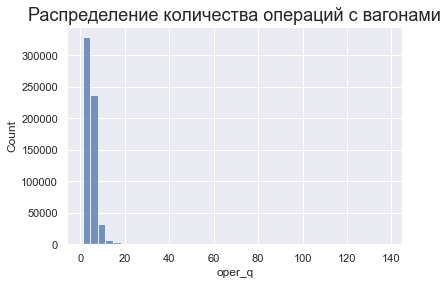

In [106]:
# Распределение кол-ва операций

plt.rcParams['figure.figsize'] = (10, 7) # размер фигуры
sns.set_theme() # стандартный вид графика

fig = sns.histplot(data=data_check, x='oper_q', bins=40) # гистограмма
fig.set_title('Распределение количества операций с вагонами', fontdict={'fontsize': 18})

Text(0.5, 1.0, 'Распределение длительности технологических циклов')

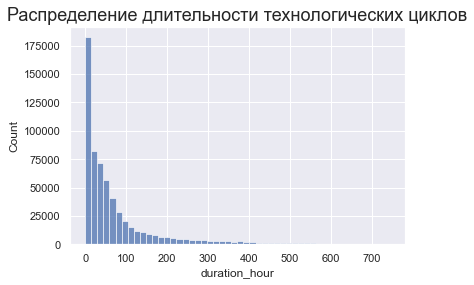

In [108]:
# Распределение длительности технологических циклов

fig = sns.histplot(data=data_check, x='duration_hour', bins=50) # гистограмма
fig.set_title('Распределение длительности технологических циклов', fontdict={'fontsize': 18})

In [109]:
# Найдём модальное значение длины технологического цикла в часах

data_check['duration_hour'].mode()[0]



0.0

Наиболее часто встречается ситуация, когда технологический цикл укладывается в 45 часов

In [110]:
# Разобъем dataset на два по длительности цикла - до 36 и более 36часов
data_check_smoll = data_check[data_check['duration_hour']<=36]
data_check_big = data_check[data_check['duration_hour']>36]

In [111]:
# Род вагона
data_check['rodvag'].value_counts()

60    325699
70     56084
96     42960
90     29937
40     25818
20     17778
93      3252
95      3219
92      2217
87      1272
99         9
Name: rodvag, dtype: int64

In [112]:
data_check_smoll['rodvag'].value_counts()

60    169865
70     21769
96     16288
40     12404
90     12270
20      7018
95      1208
93       940
92       728
87       350
99         4
Name: rodvag, dtype: int64

In [113]:
data_check_big['rodvag'].value_counts()# распределение рода вагонов примерно одинаковое в двух выборках

60    155834
70     34315
96     26672
90     17667
40     13414
20     10760
93      2312
95      2011
92      1489
87       922
99         5
Name: rodvag, dtype: int64

Text(0.5, 1.0, 'Род вагона - циклы свыше 36 часов')

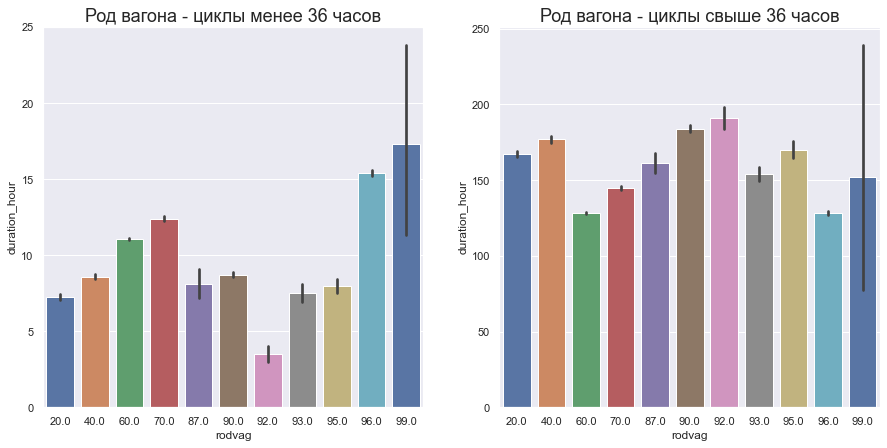

In [117]:
# График - род вагона для циклов более и менее 36 часов

fig1, (ax1) = plt.subplots(ncols=2, figsize=(15, 7))

sns.barplot(data=data_check_smoll, x='rodvag', y='duration_hour', ax=ax1[0], palette="deep")
ax1[0].set_title('Род вагона - циклы менее 36 часов', fontdict={'fontsize': 18})

sns.barplot(data=data_check_big, x='rodvag', y='duration_hour', ax=ax1[1], palette="deep")
ax1[1].set_title('Род вагона - циклы свыше 36 часов', fontdict={'fontsize': 18})

Возможно речь про то, что в зависимости от рода/типа вагона - его стараются быстрее включить в поезд. В половине случаев успевают за 36 часов. Если станция разгрузки является конечной, то длительность цикла до следующего включения в поезд выше 36 часов.

In [119]:
data_check.to_csv('G:\\MiSiS\\hakaton\\new\\df_includes_check_poezd.csv')

Построение Модели

In [120]:
data = pd.read_csv('G:\\MiSiS\\hakaton\\new\\df_includes_check_poezd.csv')
data

,Unnamed: 0.1,Unnamed: 0,operation_st_esr,car_number,operation_car,operation_car_f,operation_l,operation_date,operation_train,oper_all,oper_q,time_oper_f,time_oper_l,time_diff,stnazn,danger,gruz,rodvag,tare_weight,duration,duration_hour
0,3,3,"830,003",24579856,3,3,4,2020-07-26 18:38:00,4,"[3.0, 80.0, 19.0, 81.0, 81.0, 4.0, 3.0, 18.0, ...",9,2020-07-26 18:38:00,2020-07-29 06:02:00,2 days 11:24:00,"830,003",0,0,20,NaN,2 days 11:24:00,59
1,4,4,"830,003",24622276,3,3,4,2020-07-15 23:32:00,4,"[3.0, 80.0, 28.0, 19.0, 81.0, 81.0, 4.0]",7,2020-07-15 23:32:00,2020-07-17 04:27:00,1 days 04:55:00,"830,003",0,0,20,NaN,1 days 04:55:00,29
2,5,5,"830,003",28034288,3,3,4,2020-07-25 00:21:00,4,"[3.0, 80.0, 28.0, 19.0, 81.0, 81.0, 4.0]",7,2020-07-25 00:21:00,2020-07-28 05:40:00,3 days 05:19:00,"830,003",0,0,20,NaN,3 days 05:19:00,77
3,6,6,"830,003",28035533,28,28,4,2020-07-22 08:40:00,0,"[28.0, 19.0, 81.0, 81.0, 4.0]",5,2020-07-22 08:40:00,2020-07-23 05:04:00,0 days 20:24:00,"830,003",0,"693,227",20,267,0 days 20:24:00,20
4,7,7,"830,003",28035723,3,3,4,2020-07-23 16:57:00,4,"[3.0, 81.0, 4.0, 4.0, 4.0]",5,2020-07-23 16:57:00,2020-07-25 08:47:00,1 days 15:50:00,"830,003",0,0,20,NaN,1 days 15:50:00,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610536,980485,980485,"998,100",62175377,3,3,4,2020-07-25 05:24:00,4,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,"998,100",0,0,60,NaN,4 days 09:36:00,106
610537,980486,980486,"998,100",63694087,20,20,4,2020-07-27 08:00:00,0,"[20.0, 18.0, 79.0, 4.0]",4,2020-07-27 08:00:00,2020-07-28 04:00:00,0 days 20:00:00,"998,100",0,"323,058",60,239,0 days 20:00:00,20
610538,980487,980487,"998,100",63750566,3,3,4,2020-07-25 05:24:00,4,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,"998,100",0,0,60,NaN,4 days 09:36:00,106
610539,980490,980490,"998,100",66288432,3,3,4,2020-07-25 05:24:00,4,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,"998,100",0,0,60,NaN,4 days 09:36:00,106


In [122]:
data['st_vag'] = data.apply(lambda row: (row.operation_st_esr, row.car_number), axis=1)
data['attach_36hours'] = data['duration_hour'].apply(lambda x: 1 if x <= 36 else 0)
#Количество операций
data['oper_q'].max()

138

In [123]:
# Сформируем из ДатаСета выборку признаков
data_tr = data[['st_vag', 'oper_q', 'attach_36hours']].copy()
data_tr

,st_vag,oper_q,attach_36hours
0,"(830003.0, 24579856)",9,0
1,"(830003.0, 24622276)",7,1
2,"(830003.0, 28034288)",7,0
3,"(830003.0, 28035533)",5,1
4,"(830003.0, 28035723)",5,0
...,...,...,...
610536,"(998100.0, 62175377)",6,0
610537,"(998100.0, 63694087)",4,1
610538,"(998100.0, 63750566)",6,0
610539,"(998100.0, 66288432)",6,0


In [124]:
# Импорт библиотек для обучения
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score

In [125]:
def metrics(y_test, y_pred):
   
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred).round(5)
    recall = recall_score(y_test, y_pred).round(5)
    roc_auc = roc_auc_score(y_test, y_pred).round(5)
    f1 = f1_score(y_test, y_pred).round(5)
    accuracy = accuracy_score(y_test, y_pred)
    
  
    print('Матрица:')
    print(conf_matrix)
    print('точность (precision) - ', precision)
    print('полнота (recall) -', recall)
    print('roc_auc - ', roc_auc)
    print('f1_score - ', f1)
    print('accuracy - ', accuracy)


In [126]:
RANDOM_STATE = 36

In [127]:
X = data_tr.drop(['st_vag', 'attach_36hours'], axis=1)
Y = data_tr['attach_36hours']
# Разобъем нашу выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=RANDOM_STATE, shuffle=True, stratify=Y)
# Разделим X_train на тестовую и валидационную выборки
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train,Y_train, test_size=0.3, random_state=RANDOM_STATE, shuffle=True, stratify=Y_train)

In [ ]:
#RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE)
RFC = RFC.fit(X_train, Y_train)
Y_pred = RFC.predict(X_test)
metrics(Y_test, Y_pred)




In [ ]:
RFC.n_features_in

In [ ]:
# Подбор гиперпараметров
n_estimators = [10, 25, 40, 60,75]
max_features = [4,6,8,10]
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(RFC, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_valid, Y_valid)
RFC = gs.best_estimator_
gs.best_params_

In [ ]:
RFC_bp = RandomForestClassifier(n_estimators=50, 
                                    bootstrap=False,
                                    max_depth=15,
                                    max_features='sqrt',
                                    min_samples_leaf=2,
                                    min_samples_split=2,
                                    random_state=RANDOM_STATE)
RFC_bp = RFC_bp.fit(X_train, Y_train)
Y_pred = RFC_bp.predict(X_test)
metrics(Y_test, Y_pred)

In [ ]:
RFC_bp.n_features_in